<a href="https://colab.research.google.com/github/liajuliez/python_course/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%BE%D1%82%D0%B7%D1%8B%D0%B2%D0%BE%D0%B2_UrbanFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/943 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

Топ-10 ключевых слов по TF-IDF:
зал: 15.44
клуб: 9.58
хороший: 8.82
тренажер: 8.70
раздевалка: 6.80
народ: 6.74
абонемент: 6.52
новый: 6.26
администратор: 5.22
тренер: 5.19


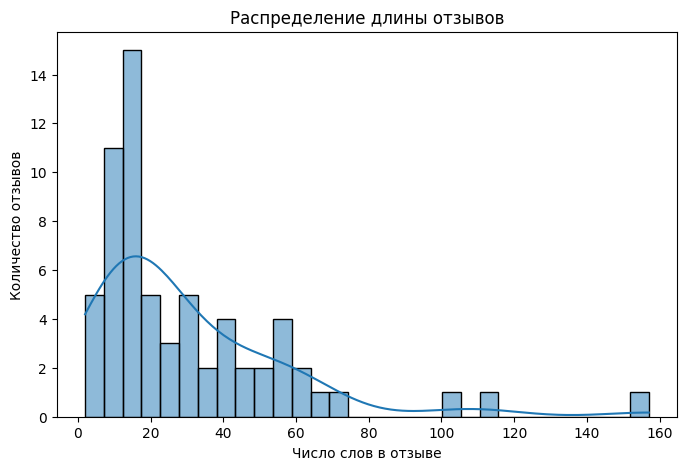

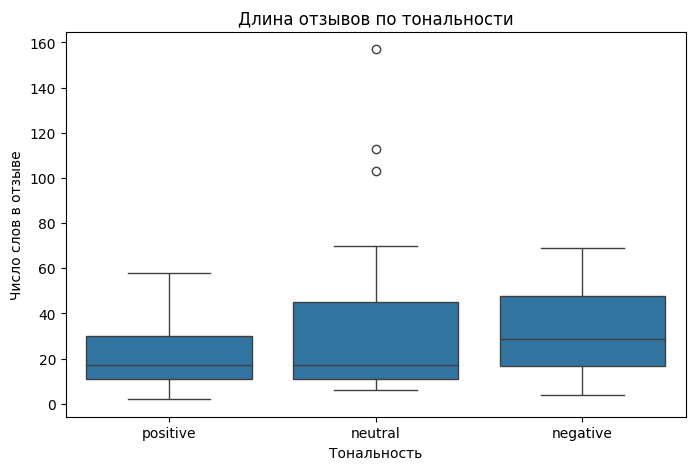

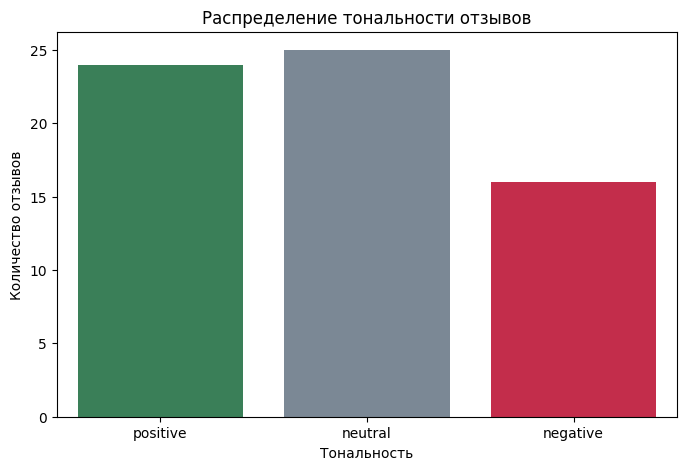

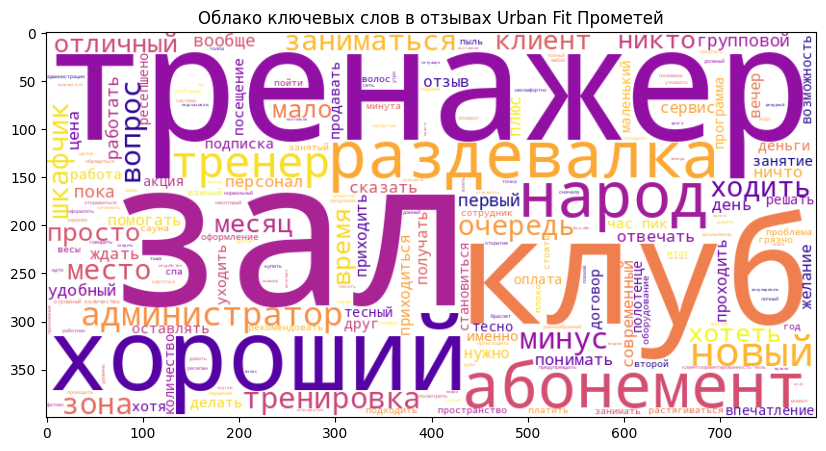

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews_urbanfit_1.csv')

# Предобработка текста с расширенным стоп-листом
nltk.download('stopwords')
mystem = Mystem()

# Расширяем стандартный стоп-лист дополнительными словами
extra_stopwords = set([
    'это', 'весь', 'человек', 'самый', 'очень', 'такой', 'ещё', 'мочь', 'большой', 'другой', 'свой', 'наш', 'ваш',
    'тот', 'так', 'уже', 'или', 'даже', 'ему', 'при', 'про', 'чтобы', 'чтоб', 'который', 'кто', 'что', 'где', 'когда', 'куда', 'откуда', 'почему',
    'зачем', 'потому', 'поэтому', 'какой', 'какая', 'какое', 'какие', 'комментарий'
])
stop_words = set(stopwords.words('russian')).union(extra_stopwords)  # Итоговый стоп-лист

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', ' ', text)
    tokens = mystem.lemmatize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]  # Убираем стоп-слова и короткие слова (<=2 символов)
    return ' '.join(tokens)

df['clean_review'] = df['review'].apply(preprocess_text)  # Применяем предобработку ко всем отзывам

# Анализ тональности
tokenizer = AutoTokenizer.from_pretrained('blanchefort/rubert-base-cased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment')

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        predicted = torch.argmax(probs, dim=1).item()
        labels = ['neutral', 'positive', 'negative']
        return labels[predicted]

df['sentiment'] = df['clean_review'].apply(predict_sentiment)  # Анализируем тональность каждого отзыва

# Ключевые слова с TF-IDF (с учетом расширенного стоп-листа)
vectorizer = TfidfVectorizer(max_features=20)  # Ограничиваем до 20 ключевых слов
tfidf_matrix = vectorizer.fit_transform(df['clean_review'])
feature_names = vectorizer.get_feature_names_out()  # Получаем список слов (признаков)

tfidf_sum = tfidf_matrix.sum(axis=0)  # Суммируем TF-IDF значения по всем отзывам для каждого слова
tfidf_scores = [(word, tfidf_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]  # (слово, сумма TF-IDF)
tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:10]  # Топ-10 по убыванию

print('Топ-10 ключевых слов по TF-IDF:')
for word, score in tfidf_scores:
    print(f'{word}: {score:.2f}')

# Визуализация: распределение по длине отзывов
df['review_length'] = df['clean_review'].apply(lambda x: len(x.split()))  # Считаем количество слов в каждом отзыве

plt.figure(figsize=(8, 5))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title('Распределение длины отзывов')
plt.xlabel('Число слов в отзыве')
plt.ylabel('Количество отзывов')
plt.show()

# Визуализация: boxplot длины отзывов по тональности
plt.figure(figsize=(8, 5))
sns.boxplot(x='sentiment', y='review_length', data=df, order=['positive', 'neutral', 'negative'])
plt.title('Длина отзывов по тональности')
plt.xlabel('Тональность')
plt.ylabel('Число слов в отзыве')
plt.show()

# Визуализация по тональности
palette = ['Crimson', 'LightSlateGrey', 'SeaGreen']  # свои цвета баров
plt.figure(figsize=(8,5))
sns.countplot(x='sentiment', hue='sentiment', data=df, order=['positive', 'neutral', 'negative'], palette=palette, legend=False)
plt.title('Распределение тональности отзывов')
plt.xlabel('Тональность')
plt.ylabel('Количество отзывов')
plt.show()

# Визуализация: облако слов
all_text = ' '.join(df['clean_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Облако ключевых слов в отзывах Urban Fit Прометей')
plt.show()